In [2]:
%matplotlib inline
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import exp

target = 100
isf = 80

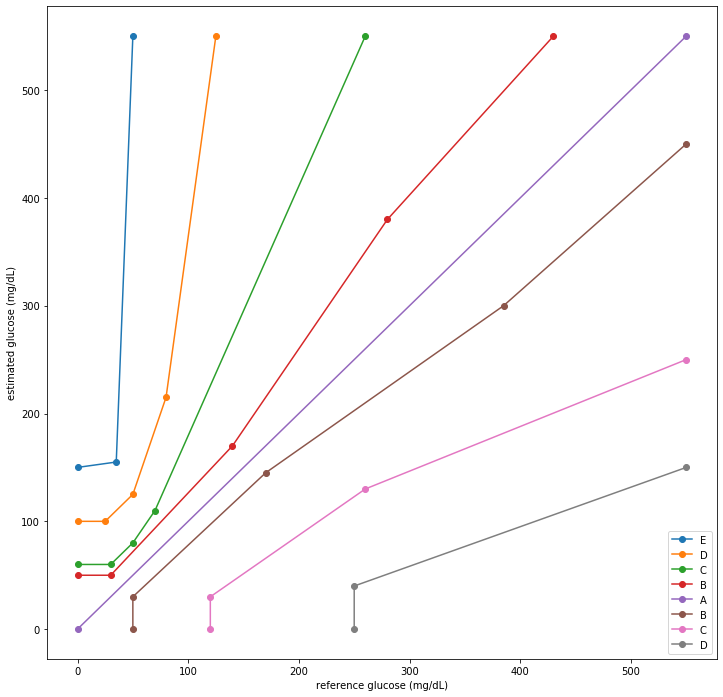

In [33]:
# Parkes Error Grid
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3876371/

lines = [
  [[0, 35, 50], [150, 155, 550], "E"],
  [[0, 25, 50, 80, 125], [100, 100, 125, 215, 550], "D"],
  [[0, 30, 50, 70, 260], [60, 60, 80, 110, 550], "C"],
  [[0, 30, 140, 280, 430], [50, 50, 170, 380, 550], "B"],
  [[0, 550], [0, 550], "A"],
  [[50, 50, 170, 385, 550], [0, 30, 145, 300, 450], "B"],
  [[120, 120, 260, 550], [0, 30, 130, 250], "C"],
  [[250, 250, 550], [0, 40, 150], "D"]
]

plt.figure(figsize=(12,12))
for line in lines:
    plt.plot(line[0], line[1], label=line[2], marker = 'o')
plt.legend(loc='lower right')
plt.xlabel('reference glucose (mg/dL)')
plt.ylabel('estimated glucose (mg/dL)')
plt.show()


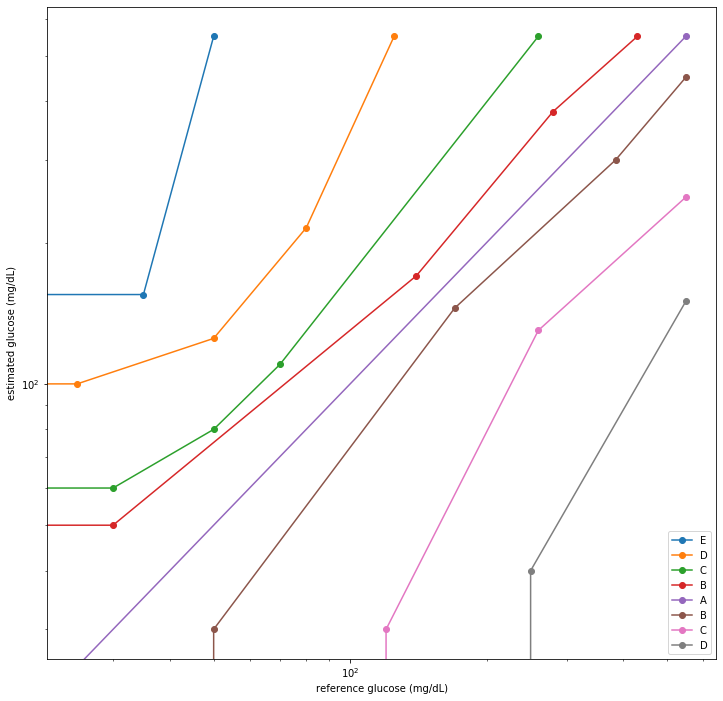

In [34]:

plt.figure(figsize=(12,12))
for line in lines:
    plt.plot(line[0], line[1], label=line[2], marker = 'o')
plt.legend(loc='lower right')
plt.xlabel('reference glucose (mg/dL)')
plt.ylabel('estimated glucose (mg/dL)')
plt.xscale("log")
plt.yscale("log")
plt.show()